In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import heapq
import random

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import CCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize, scale, StandardScaler

In [2]:
GLOVE_PATH = '/mnt/guanabana/raid/data/datasets/GloVe/pretrained/glove.6B.300d.txt'
CAVS_PATH = '../data/filtered_broden_cavs.pickle'
EMBEDDING_PATH = '../data/word_embedding_6B_300D.pickle'

Read the concept activation vectors from the Broden dataset as a dictionary

In [3]:
with open(CAVS_PATH, 'rb') as handle:
        cavs_broden = pickle.load(handle)

Extract the word embeddings from the GloVe dataset. The word embeddings are stored in a dictionary, with the word as key and vector as value, and in a matrix (400 000 x 300). The dataset contains about 400K words.

In [4]:
if os.path.exists(EMBEDDING_PATH):
    with open(EMBEDDING_PATH, 'rb') as handle:
        embedding_dict = pickle.load(handle)

    glove_embedding_matrix = np.load('../data/glove_embedding_matrix.npy')
else:
    embedding_dict = {}
    glove_embedding_matrix = np.asarray(range(300)).reshape(1,-1)

    with open(GLOVE_PATH, 'r', encoding="utf-8") as f:
        for line in tqdm(f):
            
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], 'float32')
            embedding_dict[word] = vector

            glove_embedding_matrix = np.append(glove_embedding_matrix, vector.reshape(1,-1),0)
                        
    with open(EMBEDDING_PATH, 'wb') as handle:
        pickle.dump(embedding_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    glove_embedding_matrix = glove_embedding_matrix[1:]   
    np.save('../data/glove_embedding_matrix.npy', glove_embedding_matrix)

Select the concepts from the Broden dataset, which are also available as word embedding. Several concepts in the Broden dataset end with _'-s'_. This is removed to get more concepts linked with an embedding. 

In [5]:
concepts = list(cavs_broden.keys())

# create a matrix of all cavs
cav_matrix = cavs_broden[concepts[0]]['cav']
for i in range(1, len(concepts)):
    cav = cavs_broden[concepts[i]]['cav']
    cav_matrix = np.concatenate((cav_matrix, cav), 0)

In [6]:
cav_matrix.shape

(722, 2048)

Remove the '-s' from the _scene_ concepts and store the matching cavs with the word embeddings. The index is stored to remove the unavailable concepts from the CAV matrix

In [7]:
concepts = [c[:-2] if c[-2:] == '-s' else c for c in concepts]
concepts = list(set(concepts))

embedding_concepts = [(idx, c) for idx, c in enumerate(concepts) if c in embedding_dict.keys()]

# store the indices of concepts which are present in both datasets
embedding_idxs = [ix for ix, n in embedding_concepts]

In [8]:
print("The amount of CAVs with a corresponding word embedding: ", len(embedding_idxs))

The amount of CAVs with a corresponding word embedding:  418


In [9]:
cavs_with_embedding = cav_matrix[embedding_idxs]

In [10]:
cavs_with_embedding.shape

(418, 2048)

Create a matrix of the word embeddings for the concepts which also have a CAV.

In [11]:
emb_with_cav = embedding_dict[embedding_concepts[0][1]].reshape(1,-1) #reshape the vector to a single row vector
for i in range(1, len(embedding_concepts)):
    word_vec = embedding_dict[embedding_concepts[i][1]].reshape(1,-1)
    emb_with_cav = np.concatenate((emb_with_cav, word_vec))

In [12]:
emb_with_cav.shape

(418, 300)

In [13]:
indices = list(range(len(emb_with_cav)))

In [14]:
test_idxs = np.asarray(random.sample(indices, 42))

Divide the matrices into train and test data with a 10% split

In [15]:
# use the GloVe word embeddings as input data
X_train = np.delete(emb_with_cav, test_idxs, axis=0)
X_test = emb_with_cav[test_idxs]
    
# use the CAVs as 'labels' for the word embedding
y_train = np.delete(cavs_with_embedding, test_idxs, axis=0)
y_test = cavs_with_embedding[test_idxs]

Initialize a canonical correlation model

In [ ]:
# test_concepts = concepts[:10]

# test_cav_matrix = cavs_with_embedding[:10]
# test_glove_matrix = emb_with_cav[:10]

In [17]:
n_dimensions = 2
cca = CCA(n_components = n_dimensions, scale = True, max_iter = 10000, tol=1e-06)

In [18]:
cca.fit(X_train, y_train)

CCA(copy=True, max_iter=10000, n_components=2, scale=True, tol=1e-06)

In [24]:
#X_train_c, y_train_c = cca.transform(test_cav_matrix, test_glove_matrix)
X_train_c = np.dot(X_train, cca.x_weights_)
y_train_c = np.dot(y_train, cca.y_weights_)

x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_c = x_scaler.fit_transform(X_train_c)
y_train_c = y_scaler.fit_transform(y_train_c)

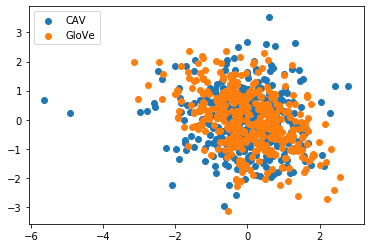

In [23]:
labels = concepts[:100]

plt.scatter(y_train_c[:,0], y_train_c[:,1], label='CAV')
plt.scatter(X_train_c[:,0], X_train_c[:,1], label='GloVe')

plt.legend()

# for i, txt in enumerate(concepts):
#     plt.annotate(str(txt), (X_train_c[:,0][i], X_train_c[:,1][i]))
#     plt.annotate(str(txt), (y_train_c[:,0][i], y_train_c[:,1][i]))

In [33]:
X_test_c = np.dot(X_test, cca.x_weights_)
y_test_c = np.dot(y_test, cca.y_weights_)

X_test_c = x_scaler.fit_transform(X_test_c)
y_test_c = y_scaler.fit_transform(y_test_c)

array([[-3.39695793e-01, -1.84420454e-01,  7.96136808e-01,
         9.95357192e-01, -9.61620146e-01,  3.41081365e-01,
        -4.37745614e-01,  7.30601324e-01, -9.08344867e-02,
        -9.95363678e-01, -1.85764757e-01,  4.47808542e-01,
         5.85063453e-01,  3.22241377e-01, -7.80395397e-01,
        -6.57155676e-01, -8.15484109e-02, -9.33642043e-01,
         7.54067998e-01,  7.42405912e-01, -7.13717593e-02,
         4.98028735e-01,  5.67120474e-01, -9.73338160e-01,
         6.78038235e-01, -8.74821863e-01, -4.36562004e-01,
         9.92812486e-01,  8.89641149e-02,  1.41306485e-01,
        -7.18159146e-01, -8.12332116e-01, -7.59865817e-01,
         9.48149019e-01, -7.93700971e-01,  9.04198852e-01,
        -8.19538313e-01, -1.35509863e-01,  9.78068565e-01,
        -5.87151003e-01,  6.53387657e-01, -7.47930995e-01,
        -6.11571658e-01, -6.12632506e-01,  9.94020483e-01,
        -9.73011893e-01, -7.97059465e-01,  1.45311976e-01,
        -5.53892990e-01,  8.17605739e-01, -6.53414179e-0

In [ ]:
cca.x_std_


In [ ]:
print(cavs_c[0,:5], embeddings_c[0,:5])

In [ ]:
ix = 8
print(concepts[test_idxs[ix]])

In [ ]:
X_pred = cca.predict(X_test[ix].reshape(1,-1))

X_pred.shape

In [ ]:
test_arr = cosine_similarity(X_pred, y_test)

In [ ]:
similar_concepts = heapq.nlargest(5, range(len(test_arr.flatten())), test_arr.flatten().take)

In [ ]:
for c in similar_concepts:
    print(concepts[test_idxs[c]])

In [ ]:
similar_concepts

In [ ]:
concepts[test_idxs[43]]

In [ ]:
unique(concepts)

In [ ]:
len(set(concepts))